In [6]:
!pip install requests

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com



[notice] A new release of pip available: 22.3.1 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


### 使用 requests.post() 方法進行登入

In [7]:
login_url = 'https://member.udn.com/member/login.jsp'

In [8]:
#- 先取得 form token: authenticity_token
import requests
user_agent = 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/129.0.0.0 Safari/537.36'  
headers = {
    'User-Agent': user_agent,
    'Referer': login_url
}
session = requests.Session()
cookie_res = session.get(login_url, headers=headers)
print(f"cookies: {cookie_res.cookies}")
print(f"status code: {cookie_res.status_code}")
print(f"response headers: {cookie_res.headers}")

cookies: <RequestsCookieJar[<Cookie JSESSIONID=D05334F33C82FD6659C301E8963373BC-n2 for member.udn.com/member>, <Cookie csrfToken=-1805605649284339412 for member.udn.com/member>]>
status code: 200
response headers: {'Content-Encoding': 'gzip', 'Alt-Svc': 'h3=":443"; ma=2592000,h3-29=":443"; ma=2592000', 'Cache-Control': 'no-cache, no-store, must-revalidate', 'Content-Language': 'tw', 'Content-Type': 'text/html;charset=utf-8', 'Date': 'Wed, 02 Oct 2024 17:49:17 GMT', 'ec-version': 'All-Policy-20240823', 'EC-W': 'D', 'Expires': '0', 'Pragma': 'no-cache', 'Server': 'nginx', 'Set-Cookie': 'csrfToken=-1805605649284339412, JSESSIONID=D05334F33C82FD6659C301E8963373BC-n2; Path=/member; Secure; HttpOnly', 'Strict-Transport-Security': 'max-age=15768000', 'Vary': 'Accept-Encoding,User-Agent', 'Via': '1.1 google', 'X-U': '0826', 'Transfer-Encoding': 'chunked'}


In [9]:
session.cookies.update(cookie_res.cookies)

In [10]:
session.headers.update(headers)

In [11]:
login_post_url = 'https://member.udn.com/member/ProcessLogin'

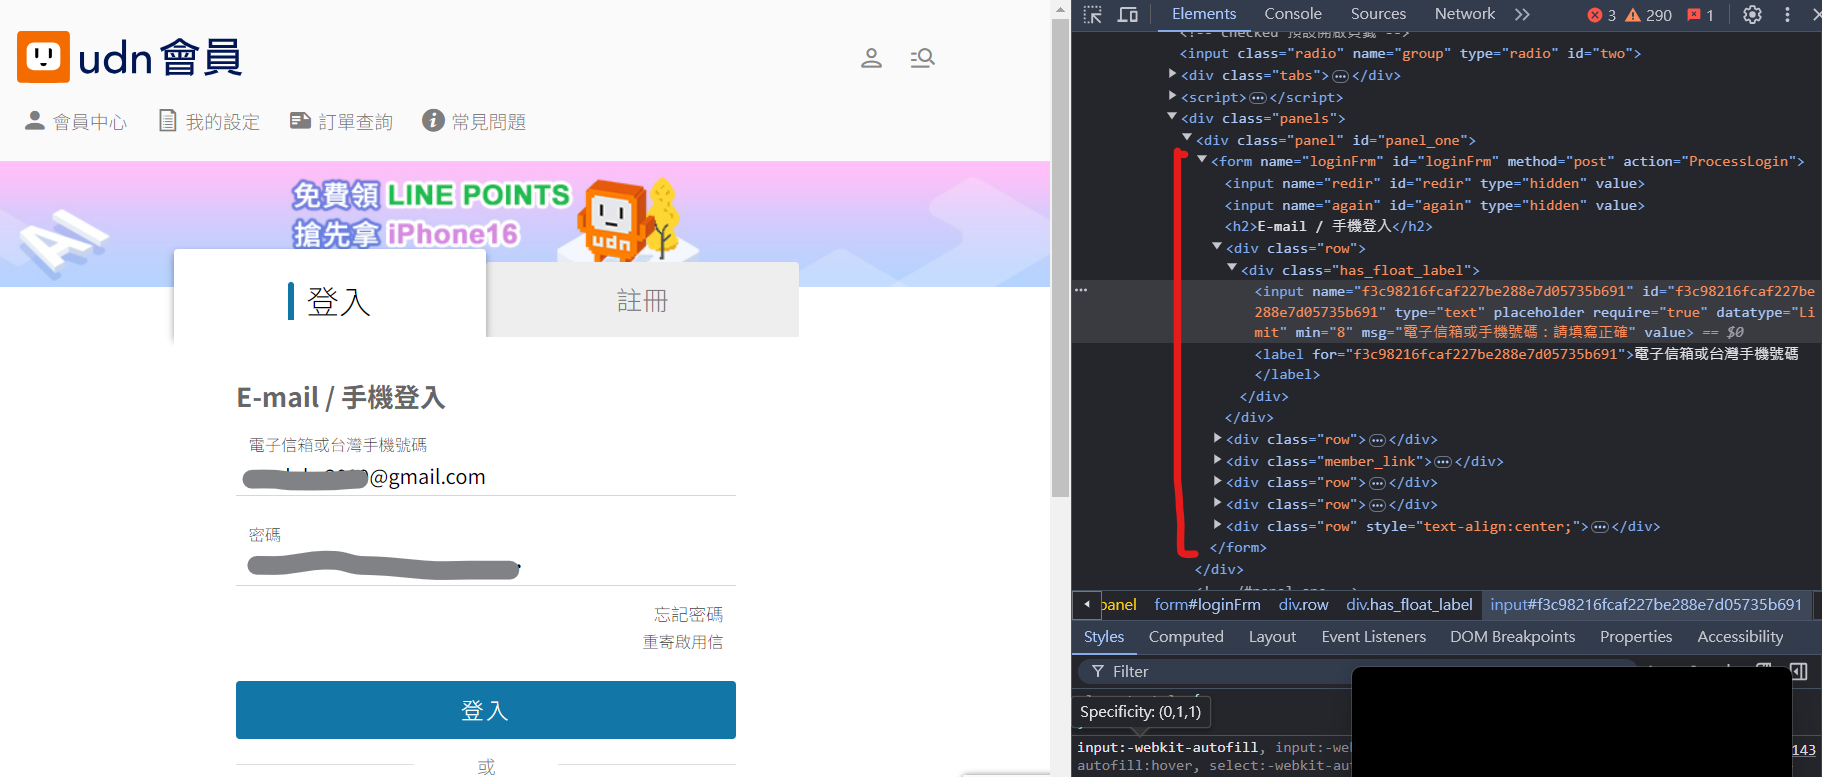

### 使用 selenium 模擬登入

In [1]:
!pip install -q selenium==4.3.0

In [2]:
!pip install -q beautifulsoup4==4.11.1

In [28]:
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
import selenium
import time
import random
import re
import sys
from bs4 import BeautifulSoup
from datetime import datetime
from selenium.webdriver import ActionChains
from selenium.webdriver.common.keys import Keys
import getpass

In [4]:
#- 不設定user agent 會被擋掉
def set_ua():
    user_agent = 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/103.0.0.0 Safari/537.36'
    return user_agent

In [5]:
def little_sleep(min=1, max=12):
    sleep_time = random.randint(min,max)
    print(f'sleep time: {sleep_time}')
    time.sleep(sleep_time)

### 設定 Selenium 和Web driver

In [8]:
def chrome_init():
    chrome_opt = webdriver.ChromeOptions()
    chrome_opt.add_argument('--headless')
    chrome_opt.add_argument('--no-sandbox')
    chrome_opt.add_argument('--disable-gpu')
    chrome_opt.add_argument('--ignore-ssl-errors=yes')
    chrome_opt.add_argument('--ignore-certificate-errors')
    chrome_opt.add_argument('--disable-dev-shm-usage') 
    chrome_opt.add_argument(f'user-agent={set_ua()}')
    # chrome_opt.add_argument("--disable-blink-features=AutomationControlled")
    chrome_opt.add_argument("--incognito")
    try:
        driver = webdriver.Remote(
            command_executor='http://selenium-hub:4444/wd/hub',
            options=chrome_opt
        )
    except Exception as e:
        print(f'chrome init error: {e}')
        raise Exception(e)
    return driver

### 打開瀏覽器並加載網頁

In [9]:
driver = chrome_init()
driver.get(login_url)
print(f"current url: {driver.current_url}")
print(f"title: {driver.title}")
driver.get_screenshot_as_file("1_1_login_page.png")

current url: https://member.udn.com/member/login.jsp
title: udn 會員中心


True

### 模擬用戶操作

In [26]:
login_email = input('請輸入登入email: ')

請輸入登入email:  madoka2000@gmail.com


In [29]:
login_password = getpass.getpass('請輸入登入密碼: ')

請輸入登入密碼:  ········


In [12]:
#- selenium 指到輸入login email欄位
email_input = driver.find_element(By.CSS_SELECTOR, '#loginFrm div.has_float_label input')
email_input.send_keys(login_email)
driver.get_screenshot_as_file("1_2_user_email.png")

True

In [13]:
#- selenium 指到輸入login password欄位
password_input = driver.find_element(By.ID, 'login_password')
password_input.send_keys(login_password)
driver.get_screenshot_as_file("1_3_user_password.png")

True

In [14]:
actions = ActionChains(driver)

# 模擬滑鼠移動
for _ in range(10):
    x = random.randint(0, 100)
    y = random.randint(0, 100)
    actions.move_by_offset(x, y).perform()
    time.sleep(random.uniform(0.1, 1))

In [15]:
#- selenium 指到login按鈕
login_button = driver.find_element(By.NAME, 'btn_submit')
little_sleep()
driver.get_screenshot_as_file("2_1_find_commit.png")

sleep time: 2


True

In [16]:
login_button.click()
# little_sleep(5,12)
driver.get_screenshot_as_file("3_1_login_click.png")

True

### 等待動態內容加載

In [17]:
#- 等待登入完成，畫面會出現"成功登入了"的文字
try:
    WebDriverWait(driver, 10).until(
        EC.text_to_be_present_in_element((By.ID, "content"), "會員中心")
    )
    print('登入成功')
    driver.get_screenshot_as_file("4_1_login_ok.png")
except TimeoutException:
    print("等待超时，未能找到指定文本。")
    driver.get_screenshot_as_file("4_2_fail_login.png")

登入成功


### 抓取和解析數據

In [18]:
driver.current_url

'https://member.udn.com/member/center.jsp'

In [19]:
content_element = driver.find_element(By.ID, 'content')

In [20]:
content_element_html = content_element.get_attribute('outerHTML')

In [21]:
print(content_element_html)

<div id="content">
<div class="main_body">

    <h1>會員中心</h1>
    <p>

    </p><div class="bah-accordion">

        <div class="bah-accordion__element">
            <input name="test-accordion" type="radio" class="bah-accordion__element__check">
            <label class="bah-accordion__element__header"><b>大家都在看</b>
			
			<a href="https://udn.com/news/story/7266/8256805" target="_blank" class="links">久坐上班族必看！每晚3肌力運動做3分鐘 有益健康還更好入睡</a>
			
			<a href="https://udn.com/mypage/" target="_blank" class="more"><i class="i-more"></i></a></label>
        </div>
        <!-- /.bah-accordion__element -->
			
        <!--<div class="bah-accordion__element">
            <input name="test-accordion" type="radio" class="bah-accordion__element__check">
            <label class="bah-accordion__element__header"><b>我的追蹤</b>
				
			<a href="https://udn.com/mypage/" target="_blank" class="more"><i class="i-more"></i></a>
			</label>
        </div>-->
        <!-- /.bah-accordion__element -->


        <div

In [22]:
soup = BeautifulSoup(content_element_html, 'html.parser')

In [23]:
driver.quit()

In [24]:
all_links = soup.select('a')

In [25]:
print(all_links)

[<a class="links" href="https://udn.com/news/story/7266/8256805" target="_blank">久坐上班族必看！每晚3肌力運動做3分鐘 有益健康還更好入睡</a>, <a class="more" href="https://udn.com/mypage/" target="_blank"><i class="i-more"></i></a>, <a class="more" href=" https://upoints.udn.com/upt/Records.do" target="_blank"><i class="i-more"></i></a>, <a class="more" href="https://udndata.com/" target="_blank"><i class="i-more"></i></a>, <a class="more" href="http://blog.udn.com/madoka2000" target="_blank"><i class="i-more"></i></a>, <a class="on" href="#myblog" id="myarticle" onclick="blog()">我的文章</a>, <a class="" href="#myblog" id="pusharticle" onclick="pushBlog()">推薦文章</a>, <a class="more" href="http://reading.udn.com/store/shelf/shelf_buy.do" target="_blank"><i class="i-more"></i></a>, <a class="on" href="#mybook" id="buybook" onclick="buyBook()">購買的電子書</a>, <a class="" href="#mybook" id="collectbook" onclick="collectBook()">個人藏書</a>]
